### imports

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt
import pickle



### load training and testing sets

In [2]:
#if loaded train file exists
try:
    with open('data/train-data.pickle', 'rb') as handle:
        train = pickle.load(handle)
#if not load and save
except:
    !unzip data/training_set_VU_DM.csv.zip
    train = pd.read_csv('training_set_VU_DM.csv')
    !rm training_set_VU_DM.csv
    with open('data/train-data.pickle', 'wb') as handle:
        pickle.dump(train, handle)

#if loaded test file exists
try:
    with open('data/test-data.pickle', 'rb') as handle:
        test = pickle.load(handle)
#if not load and save
except:
    !unzip data/test_set_VU_DM.csv.zip
    test = pd.read_csv('test_set_VU_DM.csv')
    !rm test_set_VU_DM.csv
    with open('data/test-data.pickle', 'wb') as handle:
        pickle.dump(test, handle)

### Functions

#### Submission

In [3]:
def create_submission(test_data, property_predicted_score):
    !mv submission.csv.zip prev.submission.zip
    test_data['raiting'] = property_predicted_score
    submition_data = test_data[['srch_id','prop_id','raiting']]
    submition_data = submition_data.sort_values(by=['srch_id', 'raiting'], ascending=[True,  False])
    submition_data = submition_data.drop(columns="raiting")
    submition_data.to_csv('submission.csv', index=False)
    !zip submission.csv.zip  submission.csv
    !rm submission.csv

#### ranking

In [4]:
def discountedCumulativeGain(result, k=5):
    """
    Evaluated per query
    taken from 
    https://towardsdatascience.com/normalized-discounted-cumulative-gain-37e6f75090e9
    """
    dcg = []
    for idx, val in enumerate(result[0:k]): 
        numerator = val #2**val - 1
        # add 2 because python 0-index
        denominator =  np.log2(idx + 2) 
        score = numerator/denominator
        dcg.append(score)
    return sum(dcg)


def NDCG_at_k(X, ranking, ideal_ranking, k=5):
    #create df with a querry rating and ideal rating
    #df = X[['srch_id']]
    #df.loc[: ,('ranking')] = ranking
    #df.loc[: ,('true_ranking')] = ideal_ranking

    d = {'srch_id': X['srch_id'], 'ranking': ranking, 'true_ranking': ideal_ranking}
    df = pd.DataFrame(data=d)
    df = df.sort_values(by=['srch_id', 'ranking'], ascending=[True,  False])

    NDCG  = df.groupby('srch_id').aggregate\
    (ndcg=("true_ranking", lambda x: discountedCumulativeGain(x, k)))

    df = df.sort_values(by=['srch_id', 'true_ranking'], ascending=[True,  False])
    INDCG  = df.groupby('srch_id').aggregate\
    (indcg=("true_ranking", lambda x: discountedCumulativeGain(x, k)))
    INDCG = INDCG[INDCG['indcg']!=0]
    x = NDCG['ndcg']/INDCG['indcg']# true ranking has the information regarding actual booking
    print(f'ndcg_@{k} {x.mean()}')

    return x.mean()

d = {'srch_id': [1, 1, 1, 1, 1, 1]}
df = pd.DataFrame(data=d)
ndcg_score = NDCG_at_k(df, ranking=[5, 0, 0, 0, 0, 0], ideal_ranking=[0, 0, 5, 0, 0, 0], k=5)

assert discountedCumulativeGain([0,0,5], k=5) == (5/np.log2(4)) , "assertion discountedCumulativeGain wrong"
assert ndcg_score == (5/np.log2(4))/5 , "assertion ndcg wrong"


ndcg_@5 0.5


In [5]:
   
def target_function(data_frame):
    return data_frame['click_bool'] + data_frame['booking_bool']*4 #if booked then clicked booked = 5


def hotel_booking_likelihood(data_frame, df_out):
    lklhd = data_frame.groupby('prop_id').sum().reset_index()
    counts = data_frame.groupby('prop_id').size().reset_index(name='counts')
    lklhd = lklhd[['prop_id','booking_bool']]
    lklhd = lklhd.rename(columns={"booking_bool": "lklhd"})
    lklhd['lklhd'] = lklhd['lklhd']/counts['counts']
    data_frame = data_frame.merge(lklhd, left_on='prop_id', right_on='prop_id')
    df_out = df_out.merge(lklhd, left_on='prop_id', right_on='prop_id')
    df_out.loc[df_out['lklhd'].isnull(),'lklhd'] = 0

    return data_frame, df_out

def features_engeneering(data_frame):
    #fill missing property review score by median over whole data
    for i in ['prop_review_score', 'prop_location_score2', 'orig_destination_distance']:
        data_frame.loc[data_frame[i].isnull(),i] = data_frame[i].median()

    
    
    
    #fill missing prop_log_historical_price  by country id median
    mask_log_0 = data_frame['prop_log_historical_price'] == 0
    data_frame[['historical_price']] = data_frame[['prop_log_historical_price']].applymap(np.exp)
    data_frame.loc[mask_log_0, 'historical_price'] = data_frame.loc[mask_log_0, 'price_usd']

    price_per_country_median = data_frame.groupby('prop_country_id').median().reset_index()
    price_per_country_median = price_per_country_median[['prop_country_id','price_usd']]
    price_per_country_median = price_per_country_median.rename(columns={"price_usd": "price_per_country_median"})
    data_frame = data_frame.merge(price_per_country_median, left_on='prop_country_id', right_on='prop_country_id')
    # apply median to missing values in price_usd
    mask = data_frame['price_usd']==0
    data_frame.loc[mask, 'price_usd'] = data_frame.loc[mask, 'price_per_country_median']
    mask = data_frame['historical_price']==0
    data_frame.loc[mask, 'historical_price'] = data_frame.loc[mask, 'price_per_country_median']

    # normalization
    #data_frame['price_usd'] = data_frame['price_usd']/data_frame['price_per_country_median']
    #data_frame['historical_price'] = data_frame['historical_price']/data_frame['price_per_country_median']

    # normalise by number of persons
    number_of_person = (data_frame['srch_adults_count'] + data_frame['srch_children_count']/2)
    data_frame['price_per_person_per_night'] = data_frame['price_usd']/number_of_person/data_frame['srch_length_of_stay']
        
    #
    #data standartization
    
    #for feature in ['prop_starrating','prop_location_score1']:
    #    x = data_frame[feature].values
    #    x = x.reshape(-1,1)
    #    data_frame[feature] = normalize(x)
    
    
    return data_frame

def undersample(data_frame):
    mask = data_frame['click_bool']==False
    average_non_booked = data_frame[mask].groupby('srch_id').mean().reset_index()
    
    data_frame = data_frame.drop(data_frame[mask].index)
    data_frame = data_frame.reset_index()

    data_frame = data_frame.append(average_non_booked)
    data_frame = data_frame.sort_values(by=['srch_id'], ascending=[True])
    
    #Fixing boolean values
    for feature in ['random_bool', 'prop_brand_bool','promotion_flag','srch_saturday_night_bool' ]:
        data_frame.loc[data_frame[feature]<0.5, feature] = False
        data_frame.loc[data_frame[feature]>=0.5, feature] = True
    return data_frame


### Total columns

In [6]:
len(train)

4958347

### Total null columns

In [7]:
print(train.isnull().sum())


srch_id                              0
date_time                            0
site_id                              0
visitor_location_country_id          0
visitor_hist_starrating        4706481
visitor_hist_adr_usd           4705359
prop_country_id                      0
prop_id                              0
prop_starrating                      0
prop_review_score                 7364
prop_brand_bool                      0
prop_location_score1                 0
prop_location_score2           1090348
prop_log_historical_price            0
position                             0
price_usd                            0
promotion_flag                       0
srch_destination_id                  0
srch_length_of_stay                  0
srch_booking_window                  0
srch_adults_count                    0
srch_children_count                  0
srch_room_count                      0
srch_saturday_night_bool             0
srch_query_affinity_score      4640941
orig_destination_distance

### Amount of hotels in data sets

In [8]:
x = test['prop_id']
print(f'Amount of hotels in test data {len(set(x))} ')
y = train['prop_id']
print(f'Amount of hotels in train data {len(set(y))}')
print(f'Amount of uniqe hotels in train and not in test {len(set(x) - set(y))}')

Amount of hotels in test data 129438 
Amount of hotels in train data 129113
Amount of uniqe hotels in train and not in test 7773


In [9]:
train = features_engeneering(train)
test = features_engeneering(test)
df = train.dropna(axis=1)
del train

a = set(df.columns)
b = set(test.columns)
print(f'columns not in both sets {a-b}')

columns not in both sets {'position', 'booking_bool', 'click_bool'}


### Choose features to fit

In [13]:
print(df.columns)#  the columns after droping

features_to_choose = ['visitor_location_country_id',
                      'prop_country_id', 
                      'prop_id',  
                      'prop_starrating',
                      'prop_review_score',
                      'prop_brand_bool', 
                      'prop_location_score1',
                      'prop_log_historical_price', #historical_price
                      'promotion_flag',                      
                      'srch_destination_id',
                      'srch_booking_window',
                      'srch_saturday_night_bool', 
                      'random_bool', 'lklhd', 'prop_location_score2', 'orig_destination_distance',
                      'price_per_person_per_night']

Index(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'prop_country_id', 'prop_id', 'prop_starrating', 'prop_review_score',
       'prop_brand_bool', 'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'orig_destination_distance', 'random_bool',
       'click_bool', 'booking_bool', 'historical_price',
       'price_per_country_median', 'price_per_person_per_night'],
      dtype='object')


In [11]:
#from mlxtend.frequent_patterns import apriori
#from mlxtend.frequent_patterns import association_rules
#frequent_itemsets= apriori(df[['promotion_flag','srch_saturday_night_bool', 'random_bool', 'click_bool', 'booking_bool']], min_support=0.07, use_colnames=True)
#rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
#rules = rules.sort_values(by=[ 'support', 'confidence',], ascending=False)

#rules[['antecedents', 'consequents','support','confidence']].iloc[0:10]


### Test and Evaluate

The time of evaluation fit: 4.729205846786499
ndcg_@5 0.23016418322029167
The time of evaluation fit: 18.80354952812195
ndcg_@5 0.23671367596540702
The time of evaluation fit: 19.072967290878296
ndcg_@5 0.2673074439424765
The time of evaluation fit: 24.34264326095581
ndcg_@5 0.2749819909919522
The time of evaluation fit: 44.673840045928955
ndcg_@5 0.2792854248358688
The time of evaluation fit: 56.66695189476013
ndcg_@5 0.2793648553917568
The time of evaluation fit: 64.7326021194458
ndcg_@5 0.2791007536728185
11


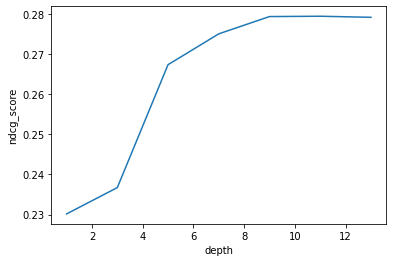

The time of evaluation fit: 301.89727115631104
ndcg_@5 0.328858349499543


In [15]:
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Fit regression model
#model = linear_model.LinearRegression()
#n_neighbors = 10
#model = neighbors.KNeighborsRegressor(n_neighbors)
#model= DecisionTreeRegressor(random_state=0)
model = RandomForestRegressor(max_depth=2, random_state=0)
#model = GradientBoostingRegressor(random_state=0)

########        EVALUATION           ###############
ind = int(len(df)*0.1)
X_train = df.iloc[0:ind, :]
X_test = df.iloc[ind:ind*2, :]

X_train, X_test = hotel_booking_likelihood(X_train, X_test)
Y_ideal = target_function(X_test)
x = []
#X_train = undersample(X_train)
depth = [x for x in range(1,15) if x % 2 != 0]
for i in depth:
    start = time.time()
    model = RandomForestRegressor(max_depth=i, random_state=0, n_jobs=-1)
    model.fit(X_train[features_to_choose], target_function(X_train))
    end = time.time()
    print("The time of evaluation fit:", end-start)
    Y_evaluation = model.predict(X_test[features_to_choose])
    ndcg_score = NDCG_at_k(X_test, ranking=Y_evaluation, ideal_ranking=Y_ideal, k=5)
    x.append(ndcg_score)
    
optimal_score_index = x.index(max(x))
optimal_depth = depth[optimal_score_index]
print(optimal_depth)# plot misclassification error vs k
plt.plot(depth, x)
plt.xlabel('depth')
plt.ylabel('ndcg_score')
plt.show()

##
ind = int(len(df)*0.5)
X_train = df.iloc[0:ind, :]
X_test = df.iloc[ind:ind*2, :]

X_train, X_test = hotel_booking_likelihood(X_train, X_test)

start = time.time()
model = RandomForestRegressor(max_depth=optimal_depth, random_state=0, n_jobs=-1)
model.fit(X_train[features_to_choose], target_function(X_train))
end = time.time()
print("The time of evaluation fit:", end-start)
Y_evaluation = model.predict(X_test[features_to_choose])
ndcg_score = NDCG_at_k(X_test, ranking=Y_evaluation, ideal_ranking= target_function(X_test), k=5)



In [ ]:
ind = int(len(df)*0.1)
X_train = df.iloc[0:ind, :]
X_test = df.iloc[ind:ind*2, :]
X_train, X_test = hotel_booking_likelihood(X_train, X_test)

model = GradientBoostingRegressor(random_state=0)
model.fit(X_train[features_to_choose], target_function(X_train))
Y_evaluation = model.predict(X_test[features_to_choose])

ndcg_score = NDCG_at_k(X_test, ranking=Y_evaluation, ideal_ranking=target_function(X_test), k=5)


##
ind = int(len(df)*0.5)
X_train = df.iloc[0:ind, :]
X_test = df.iloc[ind:ind*2, :]

X_train, X_test = hotel_booking_likelihood(X_train, X_test)

model = GradientBoostingRegressor(random_state=0)
model.fit(X_train[features_to_choose], target_function(X_train))
Y_evaluation = model.predict(X_test[features_to_choose])

ndcg_score = NDCG_at_k(X_test, ranking=Y_evaluation, ideal_ranking=target_function(X_test), k=5)



ndcg_@5 0.2828789044455859


### Fit and submit

In [ ]:
start = time.time()
df_, test_ = hotel_booking_likelihood(df, test)

model.fit(df_[features_to_choose], target_function(df))
end = time.time()
print("The time of final fit:", end-start)
raitings = model.predict(test_[features_to_choose])
create_submission(test_, raitings)